<a href="https://colab.research.google.com/github/pkdyn/satireNews/blob/main/satireNews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
from bs4 import BeautifulSoup
import string

stopwords = ["a", "about", "above", "after","afterwards", "again", "against",
             "all", "am", "an", "and", "any", "are", "as", "at","almost",
             "along","already","although", "among", "amongst", "always",
             "another", "anyhow","anyone","anything","anyway","anywhere", 
             "be", "because", "been", "before", "being", "below","beforehand", "beside", "besides",
             "between", "both", "but", "by", "could", "did", "do","couldnt",
             "does", "doing", "during", "each", "few", "for","done","detail","even","get","go","goes", 
             "from", "further", "had", "has", "have", "having","hasnt","hence",
             "he", "hed", "hes", "her", "here", "heres", "hers","hereafter","hereby","herein","hereupon",
             "herself", "him", "himself", "his", "how","hows", "i", "id","however",
             "ill", "im", "ive", "if", "in", "into","is", "it", "its","ie","inc","indeed",
             "itself","lets", "me", "more", "most", "my","myself", "nor","ltd","less","many","may","must",
              "meanwhile","might","mine","namely","neither","nevertheless","now","maybe",
             "of", "on", "once", "only", "or", "other", "ought","off","often","others","otherwise",
             "our", "ours", "ourselves", "out", "over", "own", "same", "she","perhaps","please","per","seem","seems","seemed","seeming",
             "shed", "shell", "shes", "should","since", "so", "some", "such", "than","rather","several","serious","show","shows",
             "that", "thats", "the", "their", "theirs", "them", "themselves","somehow","sometimes","still",
             "then","there", "theres", "these", "they", "theyd", "theyll","thereafter","thereby","therefore","therein",
             "theyre","theyve", "this", "those", "though","to", "too","through","throughout","thru","thus","together",
             "under", "until","up", "very", "was", "we", "wed", "well",
             "were", "weve", "were","what", "whats", "when", "whens", "where",
             "whereas","whereby","whereupon","whether","whoever","whose","will"
             "wheres", "which", "while","who", "whos", "whom", "why","whys",
             "with", "would", "you", "youd","youll", "youre", "youve", "your","yet",
             "yours", "yourself","yourselves"]

table = str.maketrans('', '', string.punctuation)

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.zip\
    -O /tmp/glove.zip


--2021-07-19 09:49:59--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 173.194.203.128, 74.125.20.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 112372936 (107M) [application/zip]
Saving to: ‘/tmp/glove.zip’

/tmp/glove.zip      100%[===================>] 107.17M   215MB/s    in 0.5s    

2021-07-19 09:50:00 (215 MB/s) - ‘/tmp/glove.zip’ saved [112372936/112372936]



In [ ]:

import numpy as np
import os
import zipfile

local_zip = '/tmp/glove.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/glove')
zip_ref.close()

glove_embeddings = dict()
f = open('/tmp/glove/glove.twitter.27B.25d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    glove_embeddings[word] = coefs
f.close()

In [ ]:
print('Loaded %s word vectors.' % len(glove_embeddings))

Loaded 1193514 word vectors.


In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json \
    -O /tmp/sarcasm.json
  
import json
with open("/tmp/sarcasm.json", 'r') as f:
    datastore = json.load(f)

sentences = [] 
labels = []
urls = []

for item in datastore:
    sentence = item['headline'].lower()
    sentence = sentence.replace(",", " , ")
    sentence = sentence.replace(".", " . ")
    sentence = sentence.replace("-", " - ")
    sentence = sentence.replace("/", " / ")
    soup = BeautifulSoup(sentence)
    sentence = soup.get_text()
    words = sentence.split()
    filtered_sentence = ""
    for word in words:
        word = word.translate(table)
        if word not in stopwords:
            filtered_sentence = filtered_sentence + word + " "
    sentences.append(filtered_sentence)
    labels.append(item['is_sarcastic'])
    urls.append(item['article_link'])

print(len(sentences))

--2021-07-19 09:59:04--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.107.128, 173.194.202.128, 74.125.135.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.107.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘/tmp/sarcasm.json’

/tmp/sarcasm.json   100%[===================>]   5.38M  --.-KB/s    in 0.03s   

2021-07-19 09:59:04 (173 MB/s) - ‘/tmp/sarcasm.json’ saved [5643545/5643545]

26709


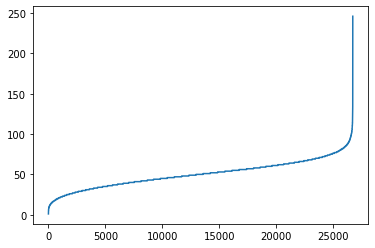

In [ ]:
xs=[]
ys=[]
current_item=1
for item in sentences:
  xs.append(current_item)
  current_item=current_item+1
  ys.append(len(item))
newys = sorted(ys)
import matplotlib.pyplot as plt
plt.plot(xs,newys)
plt.show()

In [ ]:
vocab_size = 12500
embedding_dim = 25
max_length = 85
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 21500

training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index
print(len(word_index))
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

23501


(12000.0, 14000.0, 0.8, 1.0)

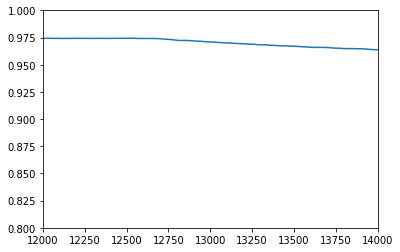

In [ ]:
xs=[]
ys=[]
cumulative_x=[]
cumulative_y=[]
total_y=0
for word, index in tokenizer.word_index.items():
  xs.append(index)
  cumulative_x.append(index)
  if glove_embeddings.get(word) is not None:
    total_y = total_y + 1
    ys.append(1)
  else:
    ys.append(0)
  cumulative_y.append(total_y / index)

import matplotlib.pyplot as plt
#fig, ax = plt.subplots(figsize=(12,2))
#ax.spines['top'].set_visible(False)

plt.plot(cumulative_x, cumulative_y)
plt.axis([12000, 14000, 0.8, 1])
#plt.margins(x=0, y=None, tight=True)
#plt.axis([0, 26000, 0, 1])
#plt.fill(ys)

In [ ]:
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, index in tokenizer.word_index.items():
    if index > vocab_size - 1:
        break
    else:
        embedding_vector = glove_embeddings.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

In [ ]:
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [ ]:
def make_model(learning_rate=0.001, size=24):
  model = tf.keras.Sequential([
      tf.keras.layers.Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], trainable=False),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, return_sequences=True, dropout=0.15) ),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, dropout=0.15)),
      tf.keras.layers.Dense(size, activation='relu'),
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])
  adam = tf.keras.optimizers.Adam(learning_rate)
  model.compile(loss='binary_crossentropy',optimizer=adam, metrics=['accuracy'])
  return model


Epoch 1/5
672/672 [==============================] - 19s 21ms/step - loss: 0.5889 - accuracy: 0.6882 - val_loss: 0.5526 - val_accuracy: 0.7232
Epoch 2/5
672/672 [==============================] - 13s 20ms/step - loss: 0.5346 - accuracy: 0.7313 - val_loss: 0.5193 - val_accuracy: 0.7395
Epoch 3/5
672/672 [==============================] - 12s 18ms/step - loss: 0.5120 - accuracy: 0.7470 - val_loss: 0.5003 - val_accuracy: 0.7560
Epoch 4/5
672/672 [==============================] - 12s 18ms/step - loss: 0.4953 - accuracy: 0.7557 - val_loss: 0.4882 - val_accuracy: 0.7614
Epoch 5/5
672/672 [==============================] - 12s 18ms/step - loss: 0.4826 - accuracy: 0.7646 - val_loss: 0.5146 - val_accuracy: 0.7428
Epoch 1/5
672/672 [==============================] - 20s 21ms/step - loss: 0.6441 - accuracy: 0.6405 - val_loss: 0.6001 - val_accuracy: 0.6848
Epoch 2/5
672/672 [==============================] - 13s 19ms/step - loss: 0.5973 - accuracy: 0.6867 - val_loss: 0.5850 - val_accuracy: 0.6963

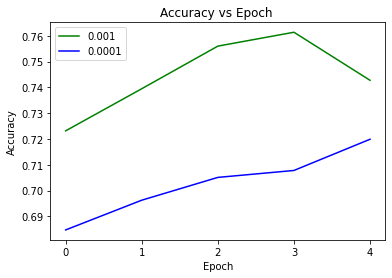

In [ ]:
num_epochs = 5
model = make_model(learning_rate=0.001)
history_001 = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels))
model = make_model(learning_rate=0.0001)
history_0001 = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels))
epochs = np.arange(5)
val_001 = history_001.history['val_accuracy']
val_0001 = history_0001.history['val_accuracy']
plt.figure(figsize=(6, 4))
plt.plot(epochs, val_001, color='green', linestyle='solid', label='0.001')
plt.plot(epochs, val_0001, color='blue', linestyle='solid', label='0.0001')
plt.title('Accuracy vs Epoch ')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(epochs)
plt.legend()
plt.show()

Epoch 1/10
672/672 [==============================] - 19s 22ms/step - loss: 0.5843 - accuracy: 0.6931 - val_loss: 0.5506 - val_accuracy: 0.7193
Epoch 2/10
672/672 [==============================] - 12s 18ms/step - loss: 0.5285 - accuracy: 0.7382 - val_loss: 0.5117 - val_accuracy: 0.7460
Epoch 3/10
672/672 [==============================] - 12s 18ms/step - loss: 0.5044 - accuracy: 0.7556 - val_loss: 0.5037 - val_accuracy: 0.7489
Epoch 4/10
672/672 [==============================] - 12s 18ms/step - loss: 0.4882 - accuracy: 0.7654 - val_loss: 0.4971 - val_accuracy: 0.7562
Epoch 5/10
672/672 [==============================] - 13s 19ms/step - loss: 0.4735 - accuracy: 0.7719 - val_loss: 0.4802 - val_accuracy: 0.7667
Epoch 6/10
672/672 [==============================] - 13s 19ms/step - loss: 0.4641 - accuracy: 0.7768 - val_loss: 0.4810 - val_accuracy: 0.7627
Epoch 7/10
672/672 [==============================] - 12s 18ms/step - loss: 0.4600 - accuracy: 0.7794 - val_loss: 0.4708 - val_accuracy:

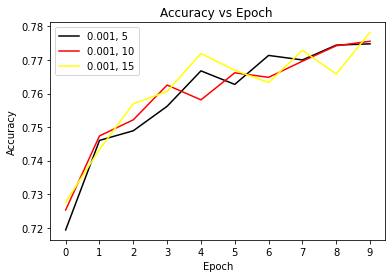

In [ ]:
num_epochs = 10
model = make_model(learning_rate=0.001, size=5)
history_001_5 = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels))
model = make_model(learning_rate=0.001, size=10)
history_001_10 = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels))
model = make_model(learning_rate=0.001, size=15)
history_001_15 = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels))
epochs = np.arange(10)
val_001_5 = history_001_5.history['val_accuracy']
val_001_10= history_001_10.history['val_accuracy']
val_001_15= history_001_15.history['val_accuracy']
plt.figure(figsize=(6, 4))
plt.plot(epochs, val_001_5, color='black', linestyle='solid', label='0.001, 5')
plt.plot(epochs, val_001_10, color='red', linestyle='solid', label='0.001, 10')
plt.plot(epochs, val_001_15, color='yellow', linestyle='solid', label='0.001, 15')
plt.title('Accuracy vs Epoch ')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(epochs)
plt.legend()
plt.show()

In [ ]:
checkpoint = keras.callbacks.ModelCheckpoint(
"xception_v1_{epoch:02d}_{val_accuracy:.3f}.h5", 
save_best_only=True, 
monitor="val_accuracy" 
)
num_epochs = 30
model = make_model(learning_rate=0.001, size=10)
history_001_10 = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), 
                            callbacks=[checkpoint])



Epoch 1/30
672/672 [==============================] - 17s 19ms/step - loss: 0.5862 - accuracy: 0.6906 - val_loss: 0.5413 - val_accuracy: 0.7270
Epoch 2/30
672/672 [==============================] - 13s 19ms/step - loss: 0.5271 - accuracy: 0.7382 - val_loss: 0.5117 - val_accuracy: 0.7449
Epoch 3/30
672/672 [==============================] - 13s 19ms/step - loss: 0.4997 - accuracy: 0.7569 - val_loss: 0.4991 - val_accuracy: 0.7541
Epoch 4/30
672/672 [==============================] - 12s 18ms/step - loss: 0.4868 - accuracy: 0.7656 - val_loss: 0.4974 - val_accuracy: 0.7525
Epoch 5/30
672/672 [==============================] - 12s 18ms/step - loss: 0.4733 - accuracy: 0.7717 - val_loss: 0.4848 - val_accuracy: 0.7629
Epoch 6/30
672/672 [==============================] - 12s 18ms/step - loss: 0.4620 - accuracy: 0.7785 - val_loss: 0.4696 - val_accuracy: 0.7700
Epoch 7/30
672/672 [==============================] - 12s 18ms/step - loss: 0.4530 - accuracy: 0.7853 - val_loss: 0.4643 - val_accuracy:

In [ ]:
test_sentences = [

"Study finds vaccine hesitancy lower in poorer countries"
"Google wants people in office, despite productivity gains at home"
"Belief In Conspiracy Theories Is Associated With Lower Levels Of Critical Thinking"


"Nobel Prize-winning fighter pilot with PhD almost meets requirements for entry level job"
"Struggling Tech Start-up Almost Desperate Enough To Start Making Actual Product"
"Tide Introduces New Ink Pen For Creating Stains On The Go"


]

sequences = tokenizer.texts_to_sequences(test_sentences)
test_pad = pad_sequences(sequences, maxlen=max_length,padding=padding_type, truncating=trunc_type)
print(model.predict(test_pad))

NameError: ignored